In [2]:
import itertools
import json
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
set_config(display='diagram')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

#### Model Tuning

In this notebook we will be tuning the Logistic Regression model using TF-IDF as our word modeling technique. We will employ grid-search to optimize hyperparameters and see if we can improve the performance of our model. Remember that the metric we are trying to maximize is the Precision of the positive class. 

In [4]:
# load training set
train = pd.read_csv('../data/final/train.csv')
train.head()

,lemma_sent,target
0,work advertise able laugh 5x magnification mir...,positive
1,adjustable stool difficult adjust finally get ...,negative
2,star soft shed,positive
3,great brush great price great brush especially...,positive
4,disappoint use korean product disappoint use k...,positive


In [12]:
# convert the "lemma_sent" column to string
train["lemma_sent"] = train["lemma_sent"].astype(str)

In [13]:
# define feature and target variables
X = train["lemma_sent"]
y = train["target"]

In [14]:
# define variables and pre-processing pipeline 
TARGETS = ["negative", "neutral", "positive"]

# define vectorizer
tfidf_vec = TfidfVectorizer()

# define classifier
log_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [24]:
# define param grid
param_grid = {
    'vec__max_features': [1000, 2500, 5000, 7500],
    'vec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vec__max_df': [.25, .5, .75, 1.0],
}

# define pipeline 
pipe = Pipeline([
    ('vec', tfidf_vec),
    ('clf', log_base)
])

# define grid search model
gs_model = GridSearchCV(
    pipe, 
    cv=5, 
    n_jobs=1, 
    param_grid=param_grid, 
    scoring='precision_micro', 
    error_score='raise', 
    verbose=2
)

In [25]:
# fit the grid search model
gs_model.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 1); total time=  15.9s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 1); total time=  15.0s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 1); total time=  15.6s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 1); total time=  16.9s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 1); total time=  15.5s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 2); total time=  23.8s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 2); total time=  24.3s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 2); total time=  24.4s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 2); total time=  21.5s
[CV] END vec__max_df=0.25, vec__max_features=1000, vec__ngram_range=(1, 2); total t

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'vec__max_df': [0.25, 0.5, 0.75, 1.0],
                         'vec__max_features': [1000, 2500, 5000, 7500],
                         'vec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='precision_micro', verbose=2)

In [26]:
# print best scores
print(gs_model.best_score_)

0.7751307548088162


In [27]:
# print best params
print(gs_model.best_params_)

{'vec__max_df': 0.25, 'vec__max_features': 7500, 'vec__ngram_range': (1, 3)}


In [28]:
# print the best model
print(gs_model.best_estimator_)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.25, max_features=7500,
                                 ngram_range=(1, 3))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])


In [29]:
# helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [30]:
# load test set for classification report
test = pd.read_csv('../data/final/test.csv')

# convert features to string type
test['lemma_sent'] = test['lemma_sent'].astype(str)

# define feature and target variables
X_test = test['lemma_sent']
y_test = test['target']

Training Set Classification Report: Logistic Regression TF-IDF

-------------------------------------
              precision    recall  f1-score   support

    negative       0.63      0.72      0.67     41707
     neutral       0.25      0.55      0.35     20714
    positive       0.96      0.81      0.88    197241

    accuracy                           0.78    259662
   macro avg       0.61      0.70      0.63    259662
weighted avg       0.85      0.78      0.80    259662

Test Set Classification Report: Logistic Regression TF-IDF

-------------------------------------
              precision    recall  f1-score   support

    negative       0.61      0.72      0.66     17803
     neutral       0.25      0.52      0.34      8826
    positive       0.96      0.81      0.88     84655

    accuracy                           0.77    111284
   macro avg       0.61      0.68      0.63    111284
weighted avg       0.84      0.77      0.80    111284

Confusion Matrix : Logistic Regression

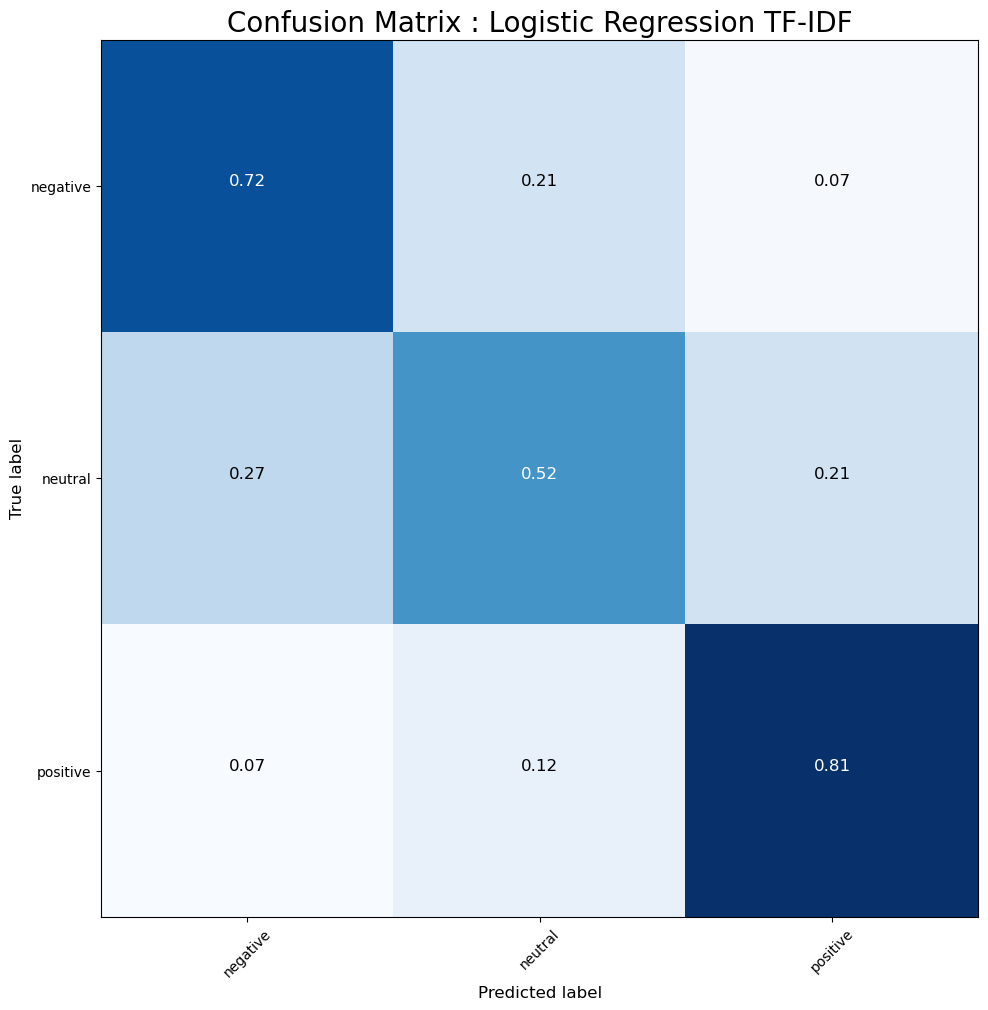

In [31]:
# print classification report and confusion matrix for best model
TARGETS = ["negative", "neutral", "positive"]

# print train classification report
y_train_pred = cross_val_predict(gs_model.best_estimator_, X, y)
print(f'Training Set Classification Report: Logistic Regression TF-IDF\n')
print('-------------------------------------')
print(classification_report(y, y_train_pred, target_names=TARGETS))

    # print test classification report
y_test_pred = cross_val_predict(gs_model.best_estimator_, X_test, y_test)
print(f'Test Set Classification Report: Logistic Regression TF-IDF\n')
print('-------------------------------------')
print(classification_report(y_test, y_test_pred, target_names=TARGETS))

# print confusion matrices
print(f'Confusion Matrix : Logistic Regression TF-IDF\n')
print('-------------------------------------')
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=TARGETS, normalize=True, title=f'Confusion Matrix : Logistic Regression TF-IDF')
plt.grid(False)
plt.savefig(f'../assets/tfidf_log_best_model.png')
plt.show()

In [32]:
# save best model to pickle file for later error analysis
joblib.dump(gs_model.best_estimator_, '../models/log-reg-tfidf-tuned.joblib')

['../models/log-reg-tfidf-tuned.joblib']